# Faster Sampling with JAX and Numba

:::{post} July 11, 2023
:tags: hierarchical model, JAX, numba, scaling
:category: How-to, intermediate
:author: Thomas Wiecki
:::

PyMC can compile its models to various execution backends through PyTensor, including:
* C
* JAX
* Numba

By default, PyMC is using the C backend which then gets called by the Python-based samplers.

However, by compiling to other backends, we can use samplers written in other languages than Python that call the PyMC model without any Python-overhead.

For the JAX backend there is the NumPyro and BlackJAX NUTS sampler available. To use these samplers, you have to install `numpyro` and `blackjax`. Both of them are available through conda/mamba: `mamba install -c conda-forge numpyro blackjax`.

For the Numba backend, there is the [Nutpie sampler](https://github.com/pymc-devs/nutpie) writte in Rust. To use this sampler you need `nutpie` installed: `mamba install -c conda-forge nutpie`. 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.0


In [2]:
warnings.filterwarnings("ignore")

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

We will use a simple probabilistic PCA model as our example.

In [45]:
def build_toy_dataset(N, D, K, sigma=1):
    x_train = np.zeros((D, N))
    w = np.random.normal(0.0, 2.0, size=(D, K))
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    for d in range(D):
        for n in range(N):
            x_train[d, n] = np.random.normal(mean[d, n], sigma)

    print("True principal axes:")
    print(w)
    return x_train


N = 5000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

data = build_toy_dataset(N, D, K)

True principal axes:
[[3.51011297]
 [1.52148378]]


Text(0.5, 1.0, 'Simulated data set')

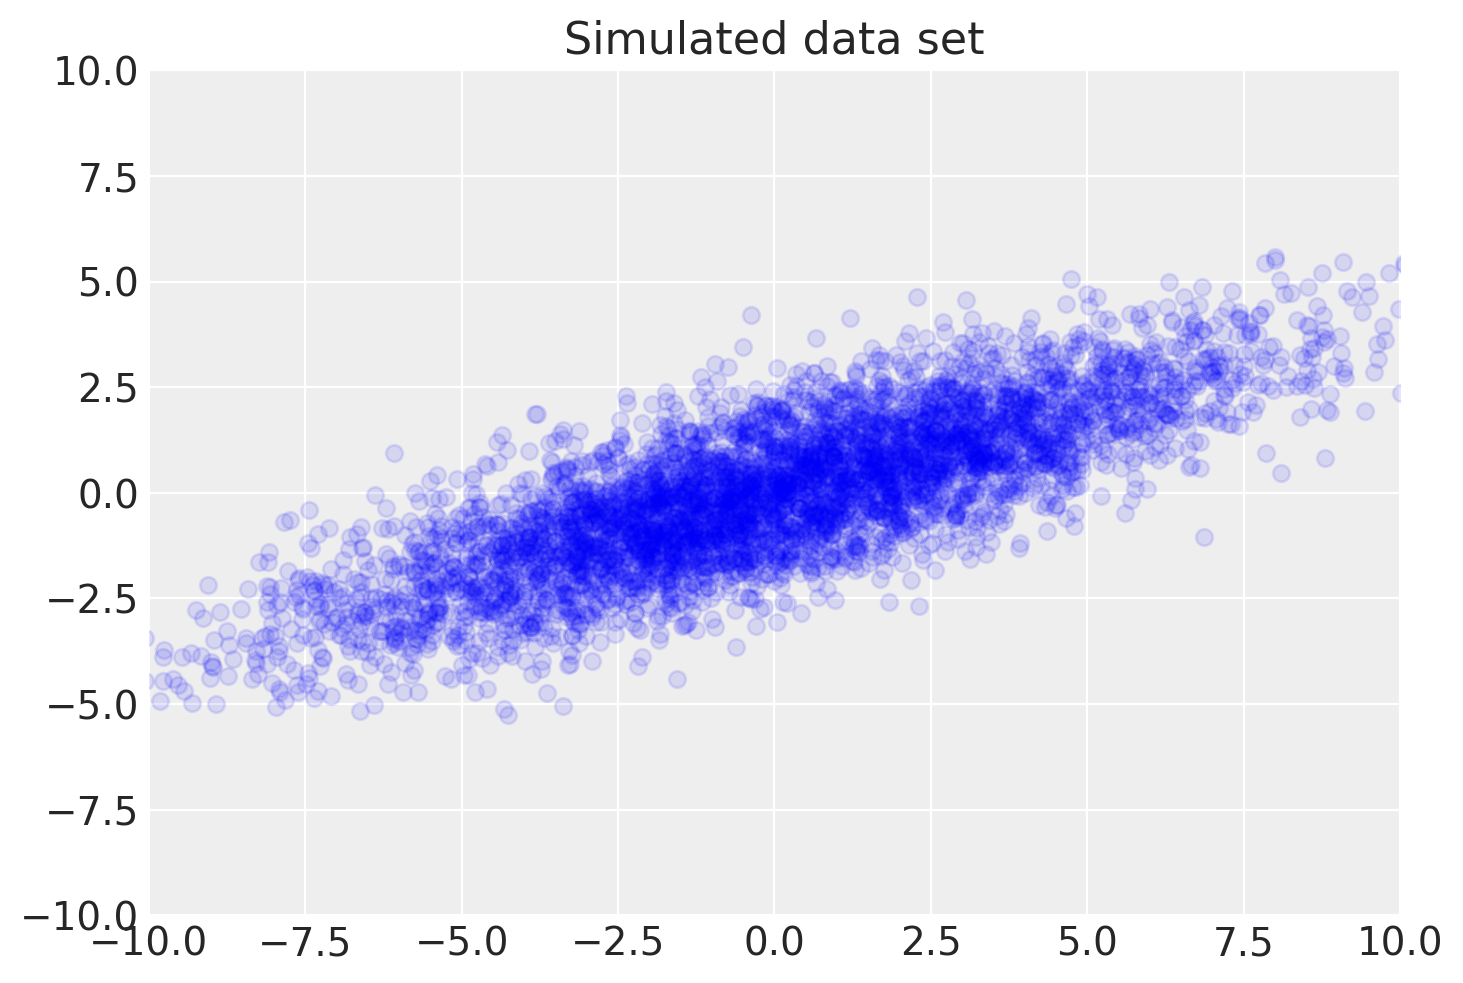

In [46]:
plt.scatter(data[0, :], data[1, :], color="blue", alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")

In [47]:
with pm.Model() as PPCA:
    w = pm.Normal("w", mu=0, sigma=2, shape=[D, K], transform=pm.distributions.transforms.Ordered())
    z = pm.Normal("z", mu=0, sigma=1, shape=[N, K])
    x = pm.Normal("x", mu=w.dot(z.T), sigma=1, shape=[D, N], observed=data)

## Sampling using Python NUTS sampler

In [48]:
%%time
with PPCA:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 19 s, sys: 900 ms, total: 19.9 s
Wall time: 43.9 s


## Sampling using NumPyro JAX NUTS sampler

In [49]:
%%time
with PPCA:
    idata = pm.sample(nuts_sampler="numpyro", progressbar=False)

Compiling...
Compilation time =  0:00:03.576687
Sampling...
Sampling time =  0:00:12.031312
Transforming variables...
Transformation time =  0:00:00.035264
CPU times: user 38.8 s, sys: 6.96 s, total: 45.7 s
Wall time: 16 s


## Sampling using BlackJAX NUTS sampler

In [50]:
%%time
with PPCA:
    idata = pm.sample(nuts_sampler="blackjax")

Compiling...
Compilation time =  0:00:00.617606
Sampling...
Sampling time =  0:00:02.513021
Transforming variables...
Transformation time =  0:00:09.774966
CPU times: user 32.8 s, sys: 6.52 s, total: 39.3 s
Wall time: 13.3 s


## Sampling using Nutpie Rust NUTS sampler

In [51]:
%%time
with PPCA:
    idata = pm.sample(nuts_sampler="nutpie")

CPU times: user 2min, sys: 40.6 s, total: 2min 41s
Wall time: 58.7 s


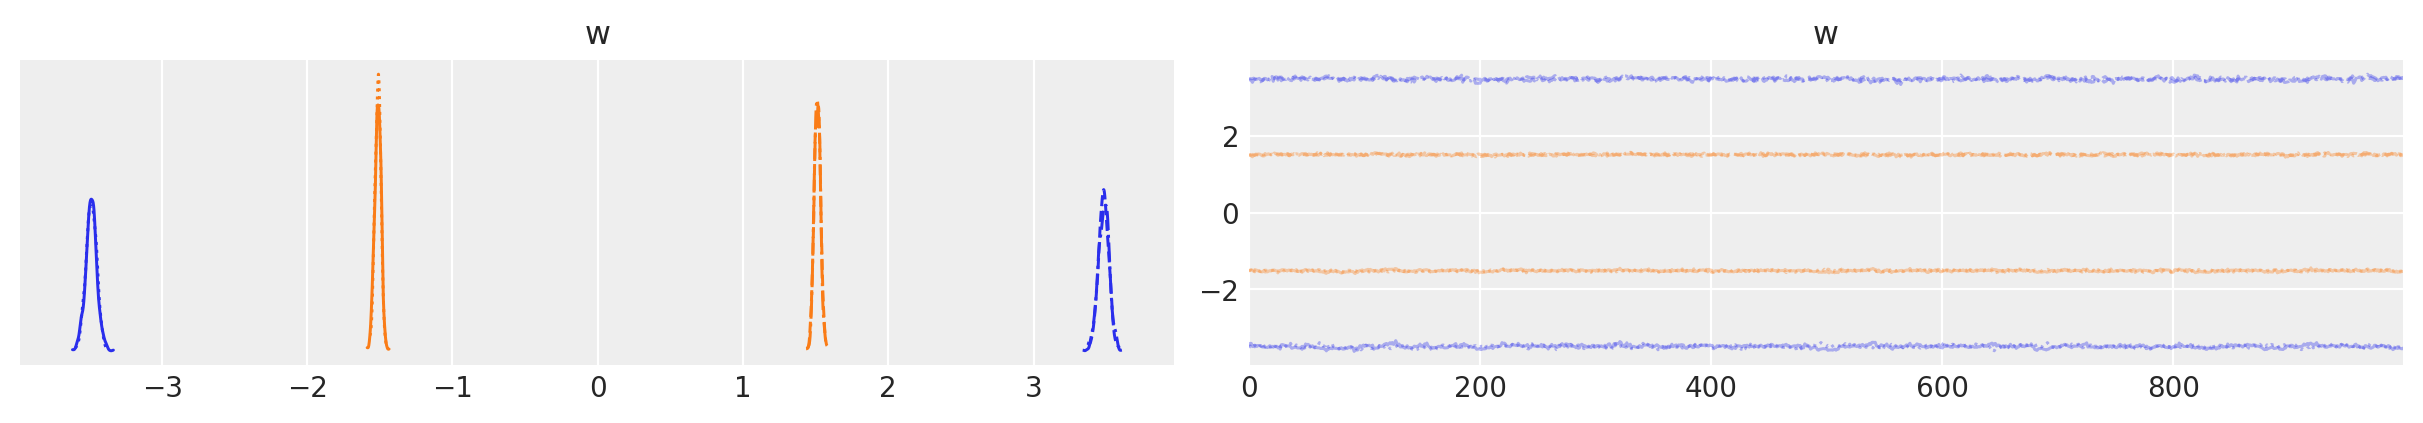

In [52]:
az.plot_trace(idata, var_names=["w"]);

In [53]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Jul 11 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

matplotlib: 3.7.1
pymc      : 5.6.0
arviz     : 0.15.1
pandas    : 2.0.3
pytensor  : 2.12.3
numpy     : 1.24.4

Watermark: 2.4.3



:::{include} ../page_footer.md
:::